# Implementation of ALEXNET

In [ ]:
import os
import io
import tensorflow as tf
import numpy as np
import pandas as pd
from azure.storage.blob import BlobServiceClient, ContainerClient
from PIL import Image
import matplotlib.pyplot as plt
import ast
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

## @Jonathan Copy Code of AlexNet
Quelle1: https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide
Quelle2: https://medium.com/@syedsajjad62/alex-net-explanation-and-implementation-in-tensorflow-and-keras-8047efeb7a0f

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

IMG_SIZE = 227
CHANNELS = 3

alexnet = Sequential()

alexnet.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= (227,227,3),
                        kernel_initializer= 'he_normal'))

alexnet.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

alexnet.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
alexnet.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

alexnet.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

alexnet.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

alexnet.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

alexnet.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                        padding= 'valid', data_format= None))

alexnet.add(Flatten())
alexnet.add(Dense(4096, activation= 'relu'))
alexnet.add(Dense(4096, activation= 'relu'))
alexnet.add(Dense(1000, activation= 'relu'))

alexnet.add(Dense(7, activation= 'softmax'))

# Compile the model:
alexnet.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

# Fit model and save history for further analysis:
history = alexnet.fit(train_ds,
                      validation_data = val_ds, 
                      epochs=50,
                      batch_size=128,
                      callbacks=[tf.keras.callbacks.EarlyStopping(patience=5), tf.keras.callbacks.ReduceLROnPlateau(patience=10)])

plot_history(history)
print_predictions(alexnet, test_ds)

### Import packages

In [2]:
import os
import io
import tensorflow as tf
import numpy as np
import pandas as pd
from azure.storage.blob import BlobServiceClient, ContainerClient
from PIL import Image
import matplotlib.pyplot as plt
import ast
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

2024-05-12 19:14:21.555031: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Connect to Azure:

In [3]:
#set up storage
connection_string = "DefaultEndpointsProtocol=https;AccountName=mlfinalexam5505462853;AccountKey=0c40lghglG5/GlNK9yujDQAgo38GKoS2I3DeC/g22hwAEIFANKpmC/TqOpRk4RCT1DbfNiHBFt72+AStB+PfUA==;EndpointSuffix=core.windows.net"
container_name = "meterml"

#create client
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

### Load images and paths

In [4]:
df = pd.read_csv("FINAL_METER_ML_test.csv")

print(df.head())


                                       Image_Folder   Type  \
0  samples/test_images/35.17852862_-79.99927082.png  CAFOs   
1      samples/test_images/47.863317_-92.810639.png  CAFOs   
2      samples/test_images/33.440833_-85.435833.png  CAFOs   
3  samples/test_images/45.12488405_-94.24194995.png  CAFOs   
4  samples/test_images/45.33317705_-94.50533971.png  CAFOs   

                   Label  
0  [1, 0, 0, 0, 0, 0, 0]  
1  [1, 0, 0, 0, 0, 0, 0]  
2  [1, 0, 0, 0, 0, 0, 0]  
3  [1, 0, 0, 0, 0, 0, 0]  
4  [1, 0, 0, 0, 0, 0, 0]  


### Train Test Split

In [5]:
# First Split:
def data_split(df):
    X_temp, X_test, y_temp, y_test = train_test_split(df['Image_Folder'], df['Label'], test_size=0.15, random_state=42)

    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)


    y_train = np.array(y_train).tolist()
    y_val = np.array(y_val).tolist()
    y_test = np.array(y_test).tolist()

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = data_split(df)

### Set Variables

In [81]:
autotune = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically

### Functions to creat data input for models

In [6]:
image_size=224
channels=3
def load_image(path):
    
    """Load an image from Azure Blob Storage."""
    blob_client = container_client.get_blob_client(path)
    blob_data = blob_client.download_blob().readall()  # Directly read all bytes
    return io.BytesIO(blob_data)

def load_and_preprocess_image(path):
    """Loads an image, decodes it to grayscale, resizes, and normalizes it."""
    # Load image
    image_file = load_image(path.numpy().decode('utf-8'))
    # Decode the image to grayscale
    image_tensor = tf.io.decode_image(image_file.getvalue(), channels=channels)
    # Resize the image
    image_resized = tf.image.resize(image_tensor, [image_size, image_size])
    # Normalize the image data
    image_normalized = image_resized / 255.0
    return image_normalized


def process_tensor(path, label):
    """Function to load an image from blob storage, decode, resize, and normalize it."""
    image_normalized = tf.py_function(load_and_preprocess_image, [path], tf.float32)
    # Ensure the shape is set correctly for grayscale
    image_normalized.set_shape([image_size, image_size, channels])
    return image_normalized, label

def create_dataset(filenames, labels, is_training=True):
    """Creates a TensorFlow dataset from filenames and labels."""
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(process_tensor, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=1024)
        
    dataset = dataset.batch(256)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

### Create Data Set for ALEXNET

In [11]:
X_train, X_val, X_test, y_train, y_val, y_test = data_split(df)
    
train_ds, test_ds, val_ds = create_all_datasets(X_train, X_val, X_test, y_train, y_val, y_test)

ValueError: Dimensions 692 and 149 are not compatible

In [9]:
def create_all_datasets(X_train, y_train, X_val, y_val, X_test, y_test):

    train_ds = create_dataset(X_train, y_train, is_training=True)
    val_ds = create_dataset(X_val, y_val, is_training=False)
    test_ds = create_dataset(X_test, y_test, is_training=False)
    
    return train_ds, val_ds, test_ds


In [ ]:
train_ds

### Print Data Set

In [10]:
for images, labels in train_ds.take(1):  # Here, take(1) takes the first batch
    print("Images:", images.numpy())  # Convert tensor to numpy array and print
    print("Labels:", labels.numpy())  # Convert tensor to numpy array and print

NameError: name 'train_ds' is not defined

### Plot one image from the data set

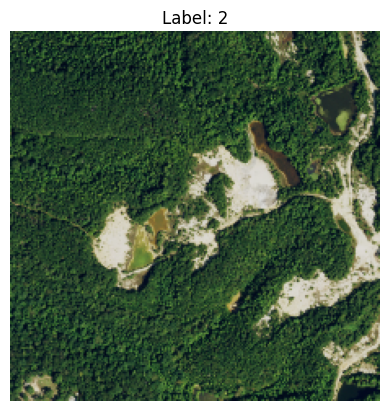

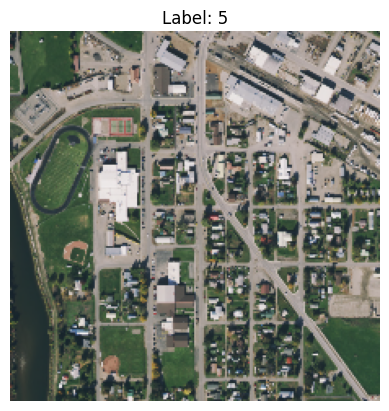

In [59]:
def plot_first_image_from_dataset(dataset, index):
    # Take one batch from the dataset
    for images, labels in dataset.take(index):
        # Assuming the image tensor is in the shape [batch_size, height, width, channels]
        # and you need the first image in the batch
        first_image = images[0]  # This is a tensor

        # Check if the image needs to be squeezed (in case it's a grayscale image with a single channel)
        if first_image.shape[-1] == 1:
            first_image = tf.squeeze(first_image, axis=-1)
        
        # Convert tensor to numpy for plotting
        first_image_np = first_image.numpy()

        # Plot the image
        plt.imshow(first_image_np, cmap='gray')
        plt.title(f'Label: {labels[0].numpy()}')
        plt.axis('off')
        plt.show()

# Example usage with your train_ds dataset
plot_first_image_from_dataset(train_ds,7)

In [60]:
#create dictionary with labels and encoded labels
unique_types = df['Type'].unique()
unique_type_encoded = df['Type_encoded'].unique()

type_dict = {}

for i in range(len(unique_types)):
    type_dict[unique_type_encoded[i]] = unique_types[i]

sorted_type_dict = dict(sorted(type_dict.items()))

sorted_type_dict

{0: 'CAFOs',
 1: 'Landfills',
 2: 'Mines',
 3: 'ProcessingPlants',
 4: 'RefineriesAndTerminals',
 5: 'WWTreatment'}

### Implement ALEXNET in KERAS t

In [84]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

IMG_SIZE = 227
CHANNELS = 3

# Set up inital AlexNet obeject:
alexnet = Sequential()

# Add convolutional layer with 64 filters of size 11x11x3 (Layer 1:)
alexnet.add(Conv2D(filters=64, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu', input_shape=(224,224,3)))

# Add Max pooling layer with pool size of 3x3 (Layer 2:)
alexnet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# Add 3 more convolutional layers with similar structure as Layer 1 (Layer 3-5:)
alexnet.add(Conv2D(filters=192, kernel_size=(5,5), padding='same', activation='relu'))
alexnet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
alexnet.add(Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'))
alexnet.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
alexnet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# Add fully connected layer with 4096 neurons (Layer 6)
alexnet.add(Flatten())
alexnet.add(Dense(4096, activation='relu'))

# Add fully connected layer with 4096 neurons (Layer 7)
alexnet.add(Dense(7, activation='softmax'))

# Compile the model:
alexnet.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

# Fit model and save history for further analysis:
history = alexnet.fit(train_ds,
                      validation_data = val_ds, 
                      epochs=50,
                      batch_size=128,
                      callbacks=[EarlyStopping(patience=5), ReduceLROnPlateau(patience=10)])

plot_history(history)
print_predictions(alexnet, test_ds)




### Alexnet
Quelle1: https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide
Quelle2: https://medium.com/@syedsajjad62/alex-net-explanation-and-implementation-in-tensorflow-and-keras-8047efeb7a0f

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

IMG_SIZE = 227
CHANNELS = 3

alexnet = Sequential()

alexnet.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= (227,227,3),
                        kernel_initializer= 'he_normal'))

alexnet.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

alexnet.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
alexnet.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

alexnet.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

alexnet.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

alexnet.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

alexnet.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                        padding= 'valid', data_format= None))

alexnet.add(Flatten())
alexnet.add(Dense(4096, activation= 'relu'))
alexnet.add(Dense(4096, activation= 'relu'))
alexnet.add(Dense(1000, activation= 'relu'))

alexnet.add(Dense(7, activation= 'softmax'))

# Compile the model:
alexnet.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

# Fit model and save history for further analysis:
history = alexnet.fit(train_ds,
                      validation_data = val_ds, 
                      epochs=50,
                      batch_size=128,
                      callbacks=[EarlyStopping(patience=5), ReduceLROnPlateau(patience=10)])

plot_history(history)
print_predictions(alexnet, test_ds)

In [85]:
alexnet_create(df)

(<keras.src.engine.sequential.Sequential at 0x7ff3cfdb4df0>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [61]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

alexnet = Sequential()

# Layer 1: Convolutional layer with 64 filters of size 11x11x3
alexnet.add(Conv2D(filters=64, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu', input_shape=(227,227,3)))

# Layer 2: Max pooling layer with pool size of 3x3
alexnet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# Layer 3-5: 3 more convolutional layers with similar structure as Layer 1
alexnet.add(Conv2D(filters=192, kernel_size=(5,5), padding='same', activation='relu'))
alexnet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
alexnet.add(Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'))
alexnet.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
alexnet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# Layer 6: Fully connected layer with 4096 neurons
alexnet.add(Flatten())
alexnet.add(Dense(4096, activation='relu'))

# Layer 7: Fully connected layer with 4096 neurons
alexnet.add(Dense(7, activation='softmax'))

In [68]:
# Compile train model
LR = 1e-5
alexnet.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [86]:
# Model summary
alexnet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 55, 55, 64)        23296     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 27, 27, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 27, 27, 192)       307392    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 13, 13, 192)       0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 13, 13, 384)       663936    
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 13, 256)      

### Fit ALEXNET Model

In [87]:
# Fit Model:
fit_alexnet = alexnet.fit(train_ds_alexnet, epochs=10, batch_size = 224, validation_data=val_ds, callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)])

Epoch 1/10


2024-05-11 19:37:41.225509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 179 of 1024
2024-05-11 19:37:51.229588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 349 of 1024
2024-05-11 19:37:53.355933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


KeyboardInterrupt: 

In [18]:
# get predicitons:
predictions_alexnet = model.predict(train_ds)

3/3 [==============================] - 7s 2s/step


In [19]:
# Check predicitons and actual labels:
for images, labels in train_ds_alexnet:
    predictions = model.predict(images)  # Only pass image data
    #print(predictions[:1])
    for pred, label in zip(predictions, labels):
        print("Prediction:", pred, "Actual Label:", label.numpy())# Print the first prediction
    break

8/8 [==============================] - 3s 380ms/step
Prediction: [0.12451011 0.12822099 0.12610371 0.20961808 0.13186908 0.13716152
 0.14251645] Actual Label: 3
Prediction: [0.12923872 0.13108133 0.12909967 0.20260534 0.13237107 0.13816814
 0.13743572] Actual Label: 6
Prediction: [0.12704179 0.13346837 0.12932992 0.19732162 0.1327646  0.13751931
 0.14255445] Actual Label: 3
Prediction: [0.12867567 0.1295986  0.12938792 0.2037487  0.1325336  0.13793737
 0.13811807] Actual Label: 3
Prediction: [0.13305245 0.13698208 0.13362932 0.18031399 0.13492134 0.13974509
 0.14135575] Actual Label: 3
Prediction: [0.13044515 0.13533752 0.12994984 0.19162254 0.13403003 0.13993537
 0.13867947] Actual Label: 0
Prediction: [0.1263755  0.12925926 0.12813939 0.20954598 0.13101928 0.13777566
 0.13788496] Actual Label: 4
Prediction: [0.12668155 0.12948947 0.12889923 0.2128678  0.13020295 0.13493654
 0.13692252] Actual Label: 3
Prediction: [0.12560235 0.12848397 0.12626109 0.21610065 0.1293531  0.13643163
 0.1